In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error
from keras.models import Model
import keras.backend as K
# from keras.losses import mean_squared_error
def rmse(actual, preds):
    return np.sqrt(np.mean((actual - preds)**2))

Using TensorFlow backend.


# Right now make as many assumptions as possible

It's better to ask it
- derive speeds
- separate x and y. mby use same module for both?
- learn bounces separately
     - is LSTM much better if there is only 1 frame after the bounce vs 0?

In [2]:
## Straight movement, derive speed

from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda

# This returns a tensor
inputs = Input(shape=(4,1,))
# inputs = Input(shape=(10,1))

# a layer instance is callable on a tensor, and returns a tensor
x = LSTM(8, return_sequences=False)(inputs)
x = Dense(4)(x)

predictions = Dense(2, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_ws = Model(inputs=inputs, outputs=predictions)
model_ws.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_ws.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


In [3]:
df = pd.read_csv('sim_data2.csv')
# x, x_vel, y, y_vel
a = df.to_numpy()
a = a.reshape((10000,10,4)) #samples x timesteps x features
X = a[:,:4,0].reshape(10000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:8000]
train_Y = Y[:8000]

# test_X = X[8000:]
# test_Y = Y[8000:]
model_ws.fit(train_X, train_Y, epochs=150, verbose=False)

In [4]:
# plt.plot(model_ws.history.history['loss'][35:])

In [5]:
test_X = X[8000:]
test_Y = Y[8000:]
rmse(test_Y, model_ws.predict(test_X))

0.00022882492940960416

In [6]:
rmse(train_Y, model_ws.predict(train_X))

0.00022820979942573798

In [7]:
model_ws.predict(train_X[[0]])

array([[ 0.19558002, -0.03846521]], dtype=float32)

In [8]:
train_Y[[0]]

array([[ 0.19550872, -0.03837913]])

In [9]:
# model_json = model_ws.to_json()
# with open("sim_e500_8000x5.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model_ws.save_weights("model_sim_e500_8000x5.h5")
# print("Saved model to disk")

# Bounces

In [10]:
inputs = Input(shape=(2,))

x = Dense(2)(inputs)

predictions = x#Dense(4, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_b = Model(inputs=inputs, outputs=predictions)
model_b.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [11]:
df = pd.read_csv('bounces_mirror.csv')
a = df.to_numpy()
a = a.reshape((2000,2,4)) #samples x timesteps x features
a = a[:,:,:2]
train_X = a[:1000,0,:]
test_X = a[1000:,0,:]
train_Y = a[:1000,1,:]
test_Y = a[1000:,1,:]
model_b.fit(train_X, train_Y, epochs=1500, verbose=False)

In [12]:
print(rmse(test_Y, model_b.predict(test_X)))
print(rmse(train_Y, model_b.predict(train_X)))

0.0001117254083936432
0.0001115315022888534


In [13]:
import matplotlib.pyplot as plt
plt.plot(model_b.history.history['loss'][50:])
plt.show()

<Figure size 640x480 with 1 Axes>

In [14]:
model_b.predict(train_X[[0]])

array([[ 0.9735662 , -0.07019996]], dtype=float32)

In [15]:
model_json = model_b.to_json()
with open("sim_e1500_b.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_b.save_weights("model_e1500_b.h5")
print("Saved model to disk")

Saved model to disk


### Attention

In [16]:
inputs = Input(shape=(2,))
x = Dense(1)(inputs)
predictions = x

model_att = Model(inputs=inputs, outputs=predictions)
model_att.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_att.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [17]:
df = pd.read_csv('bounces_att.csv')
a = df.to_numpy()
train_X = a[:1500,:2]
test_X = a[1500:,:2]
train_Y = (a[:1500,2] == True)
test_Y = (a[1500:,2] == True)
model_att.fit(train_X, train_Y, epochs=1500, verbose=False)

In [18]:
inputs = Input(shape=(2,))

x = model_att(inputs)
x = Lambda(lambda s: K.round(s))(x)
predictions = x
model_lambda = Model(inputs=inputs, outputs=predictions)
model_lambda.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['acc'])
model_lambda.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
model_3 (Model)              (None, 1)                 3         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [19]:
print(np.mean(model_lambda.predict(train_X).reshape(train_X.shape[0]) == train_Y))
print(np.mean(model_lambda.predict(test_X).reshape(test_X.shape[0]) == test_Y))

0.9553333333333334
0.956


In [20]:
model_json = model_lambda.to_json()
with open("sim_e1500_att.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lambda.save_weights("model_e1500_att.h5")
print("Saved model to disk")

Saved model to disk


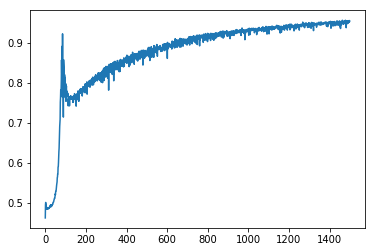

In [21]:
plt.plot(model_att.history.history['acc'])

## Bounce series

In [35]:
df = pd.read_csv('bounces_x_1.csv')
a = df.to_numpy()
a = a.reshape((1000,5,4))

X = a[:,:4,0].reshape(1000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:800]
train_Y = Y[:800]

test_X = X[800:]
test_Y = Y[800:]

In [177]:
import tensorflow as tf
bl = tf.convert_to_tensor([0,0,1,1], dtype=np.float32)
bl = tf.reshape(bl,(4,1))
tf.multiply(bl, 1)

<tf.Tensor 'Mul_28:0' shape=(4, 1) dtype=float32>

In [214]:
bl[0]

<tf.Tensor 'strided_slice:0' shape=(1,) dtype=float32>

In [231]:
inputs_rec = Input(shape=(4,1), name='input_rec')
rec = model_ws(inputs_rec)
bnc = model_b(rec)
merge = Concatenate()([rec, bnc])
# merge = tf.reshape(merge,(4,1))

att = model_lambda(rec) #tf.broadcast_to(x,(4,1))
#tf.convert_to_tensor([1-x[1],1-x[1],x[1],x[1]])
att = Lambda(lambda x: x, output_shape=(1,4)) (att)
# att = Lambda(lambda x: tf.multiply(tf.subtract(1.0, tf.broadcast_to(x,(4,1))), bl), output_shape=(4,), name="bool2arr") (att)

output = Multiply(name="mul")([merge, att])

model_m = Model(inputs=inputs_rec, outputs=att)
model_m.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_rec (InputLayer)       (None, 4, 1)              0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 366       
_________________________________________________________________
model_4 (Model)              (None, 1)                 3         
_________________________________________________________________
lambda_65 (Lambda)           (None, 1, 4)              0         
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [232]:
model_m.predict(X[:2].reshape(2,4,1))

ValueError: could not broadcast input array from shape (4,1) into shape (2,1)

In [ ]:
model_ws.predict(a[0,:4,0].reshape(1,4,1))

In [28]:
model_lambda.predict(a[3,:2,:2])

array([[0.],
       [0.]], dtype=float32)

In [30]:
a[0,:,:2].reshape(1,5,2)

array([[ 0.13330571, -0.04433828],
       [ 0.08896744, -0.04433828],
       [ 0.04462916, -0.04433828],
       [ 0.00029088, -0.04433828],
       [ 0.0001525 ,  0.04433828]])

In [42]:
model_m.predict(a[0,:4,0].reshape(1,4,1))

array([[1.]], dtype=float32)